In [ ]:
# default_exp reg

In [1]:
#export 
from sklearn.ensemble import RandomForestRegressor
import time
import numpy as np
import math
from fastcore.all import *
import pandas as pd
from autoforest.cleaner import *
from fastai.tabular.all import *
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt

main source of information to writing this is from the fastai-book
https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [2]:
filename = "Buldozers.csv"           # dataframe containing all the data
y_col_name = 'SalePrice'         # name of the column we are going to predict
split_pct = 0.2             # size of verification dataset
datefield = 'saledate'     # name of the field containing the date-part

In [3]:
df = pd.read_csv(filename, low_memory=False)

df = fix_dataframe(df, datefield= datefield, y_col_name = y_col_name)
splits = split_by_date(df, pct=0.2)
df = add_datepart(df, datefield)
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var = y_col_name)
to = TabularPandas(df, procs, cat, cont, y_names=y_col_name, splits=splits)

In [4]:
#export
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [87]:
#export
class RfRegressor:
    def __init__(self, 
                 train_x:pd.DataFrame, 
                 train_y:pd.Series, 
                 val_x:pd.DataFrame, 
                 val_y:pd.Series):
        self._train_x = train_x
        self.train_y = train_y
        self._val_x = val_x
        self.val_y = val_y
        
        self.model_class = RandomForestRegressor
        self.model = None
        self.corr = None   #correlation matrix
        self.ctd = []  #columns to drop
        
    @property
    def train_x(self):
        return self._train_x.drop(self.ctd, axis=1)
    
    @property
    def val_x(self):
        return self._val_x.drop(self.ctd, axis=1)
    
    @classmethod
    def from_dataframe(cls, df, y_col_name, splits=None):
        if splits is not None:
            splits = split_by_date(df, pct=0.2)
        
        procs = [Categorify, FillMissing]
        cont,cat = cont_cat_split(df, 1, dep_var = y_col_name)
        to = TabularPandas(df, procs, cat, cont, y_names=y_col_name, splits=splits)
        xs,y = to.train.xs, to.train.y
        valid_xs,valid_y = to.valid.xs, to.valid.y

        return cls(xs, y, valid_xs, valid_y)
    
    def drop_columns(self, cols):
        """
        Keep original dataframe and only save the columns to drop
        These columns are dropped during training/validation
        """
        if type(cols) is str: cols = [cols]
        self.ctd.extend(cols)
        #cols = list(cols)
        #for c in cols:
            #self.train_x.drop(c, axis=1, inplace=True)
            #self.val_x.drop(c, axis=1, inplace=True)
            
    def predict(self, x:pd.DataFrame):
        """
        Using x as input and predicts the y-value.
        the predicted values comes with both the mean from all decision trees and the confidence (std from all trees)
        """
        
        preds = np.stack([t.predict(x.drop(self.ctd, axis=1).values) for t in self.model.estimators_])
        conf = np.std(preds, axis=0)
        pred = np.mean(preds,axis=0)
        return pred,conf
    
    def create_model(self, min_sample_leaf:int=4, n_estimators:int=40, max_features:float=0.5):
        self.model = self.model_class(n_estimators=n_estimators, 
                                  n_jobs=-1,
                                  oob_score=True, 
                                  min_samples_leaf=min_sample_leaf,
                                  max_features=max_features)
        
    def fit(self, cols_to_drop=list()):
        result = dict()
        t0 = time.time()
        if self.model is None:
            self.create_model()
        
        if type(cols_to_drop) is str: cols_to_drop=[cols_to_drop] 
        #cols_to_drop.extend(self.ctd)

    
        print('training')
        self.model.fit(self.train_x.drop(cols_to_drop, axis=1).values, self.train_y)
        print('finished')
        
        result['train_rmse'] = rmse(self.model.predict(self.train_x.drop(cols_to_drop, axis=1).values),
                                                    self.train_y)
        result['val_rmse'] = rmse(self.model.predict(self.val_x.drop(cols_to_drop, axis=1).values),
                                                  self.val_y)
        
        if hasattr(self.model, 'oob_prediction_'):
            result['oob_error'] = rmse(self.model.oob_prediction_, self.train_y)

        if hasattr(self.model, 'oob_score_'):
            result['oob_score'] = self.model.oob_score_
        
        train_time = time.time()-t0
        print(f"training time: {train_time}")
        return result

In [88]:
reg = RfRegressor.from_dataframe(df, y_col_name, splits)
assert type(reg.ctd) is list
reg.drop_columns(['1','2'])
assert len(reg.ctd) == 2
reg.drop_columns('345')
assert len(reg.ctd) == 3

In [89]:
reg = RfRegressor.from_dataframe(df, y_col_name, splits)
reg.fit(cols_to_drop =[df.columns[1]])

training
finished
training time: 7.574860095977783


{'train_rmse': 0.1305928449400905,
 'val_rmse': 0.21337716170879995,
 'oob_error': 0.20142117701899862,
 'oob_score': 0.912565333577011}

In [90]:
reg = RfRegressor.from_dataframe(df, y_col_name, splits)
reg.fit()

training
finished
training time: 8.191095113754272


{'train_rmse': 0.12979909885044014,
 'val_rmse': 0.21411871768207247,
 'oob_error': 0.20138640582644082,
 'oob_score': 0.9125955185382263}

In [91]:
#export
@patch_to(RfRegressor)
def feature_importance(self):
    """ returns a dataframe containing all columns together with feature importance"""
    return pd.DataFrame({'cols':self.train_x.columns, 'imp':self.model.feature_importances_}
                   ).sort_values('imp', ascending=False)

In [92]:
fi = reg.feature_importance()
fi.head()

,cols,imp
57,YearMade,0.183939
6,ProductSize,0.154420
30,Coupler_System,0.075393
3,fiSecondaryDesc,0.066261
7,fiProductClassDesc,0.058140


In [93]:
#export
@patch_to(RfRegressor)
def plot_feature_importance(self, top=None, **kwargs):
    """
    Returns barplot for each column
    """
    df_fi = self.feature_importance()
    return df_fi[:top].plot('cols', 'imp', 'barh', legend=False, **kwargs)
    

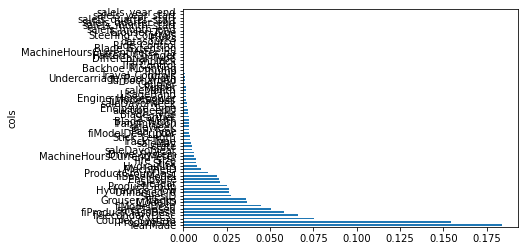

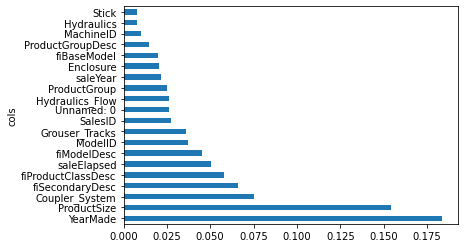

In [94]:
fi = reg.plot_feature_importance()
fi = reg.plot_feature_importance(top=20)

In [95]:
#export
@patch_to(RfRegressor)
def get_cols_of_low_imp(self, tresh=0.005):
    """
    takes a datafreame and drops all columns with a feature-imporatance lower than the defined treshold.
    this dataframe can be used to create a new regressor to hopefully improve model performace
    """
    df_feat = self.feature_importance()
    cols_to_drop = df_feat[df_feat['imp']<tresh]['cols']
    return cols_to_drop.values

    
    

In [96]:
cols_to_drop = reg.get_cols_of_low_imp()
assert 'YearMade' not in cols_to_drop
l1 = len(reg.train_x.columns)

In [97]:
reg.drop_columns(cols_to_drop)

# Clusert similar columns to find correlations

In [101]:
#export
@patch_to(RfRegressor)
def calc_correlations(self):
    self.corr = np.round(scipy.stats.spearmanr(self.train_x).correlation, 4)
    self.corr_cols = self.train_x.columns
    if np.isnan(self.corr[0,:]).any():
        # we sometimes get correlations with NaN if we have columns that do not match
        print('dropping nan correlations')
        to_keep = ~np.isnan(reg.corr[0,:])
        temp_x = self.train_x.columns[to_keep]
        self.corr = np.round(scipy.stats.spearmanr(temp_x).correlation, 4)
        self.corr_cols = to_keep

@patch_to(RfRegressor)
def plot_correlation_heatmap(self):
    if not hasattr(self, 'corr') or self.corr is None:
        self.calc_correlations()
        
    f=plt.gcf()
    plt.matshow(self.corr, fignum=f.number)
    plt.xticks(range(self.train_x.shape[1]), self.corr_cols, fontsize=14, rotation=90)
    plt.yticks(range(self.train_x.shape[1]), self.corr_cols, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    

In [103]:
reg.corr=None

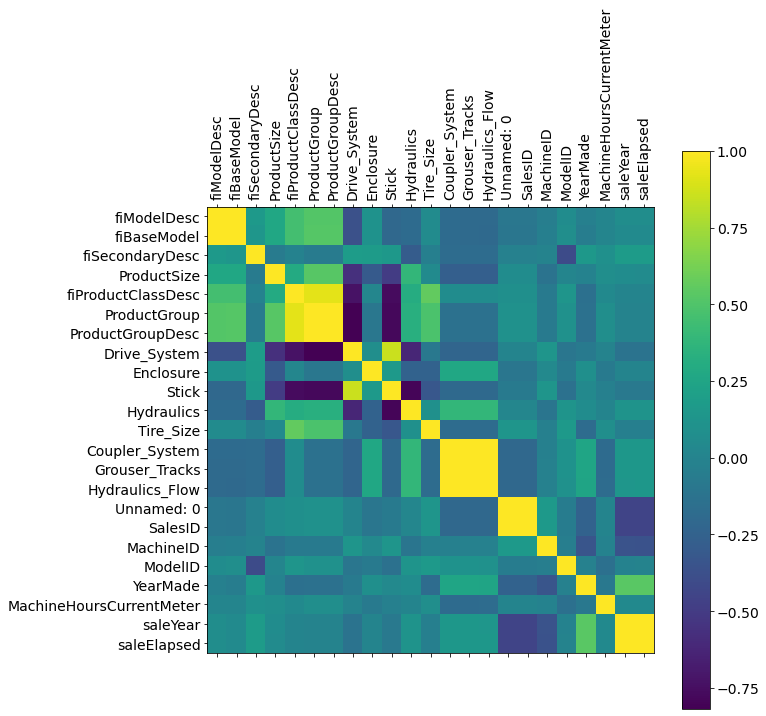

In [104]:
plt.figure(figsize=(10,10))
reg.plot_correlation_heatmap()

In [105]:
#export
@patch_to(RfRegressor)
def plot_var_linkage(self):
    if not hasattr(self, 'corr') or self.corr is None:
        self.calc_correlations()
    
    corr_condensed = hc.distance.squareform(1-self.corr)
    z = hc.linkage(corr_condensed, method='average')
    dendrogram = hc.dendrogram(z, labels=self.corr_cols, orientation='left', leaf_font_size=16)
    plt.show()

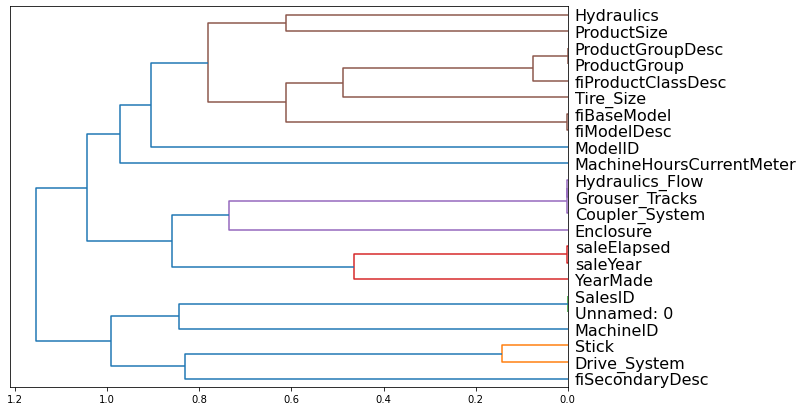

In [106]:
plt.figure(figsize=(10,7))
reg.plot_var_linkage()

In [107]:
#export
def _get_list_of_high_corr(corr, corr_limit):
    p = np.argwhere(np.triu(np.abs(corr)>corr_limit,1))
    l = list(p)
    return l
    

def _del_param_in_array(arr, value):
    for i in range(len(arr)-1,0,-1):
        if arr[i-1][0] == value:
            del arr[i-1]
                    
def _del_duplicated_columns(arr):
    i=0
    while(i<len(arr)):
        _del_param_in_array(arr,arr[i][1])
        i+=1
    return arr
    
def _arrays_to_colnames(columns,arr):
    data = dict()
    for i in range(len(arr)):
        temp = data.get(arr[i][0],list())
        if len(temp)==0:
            colname = columns[arr[i][0]]
            temp.append(colname)
        colname = columns[arr[i][1]]
        temp.append(colname)
        data[arr[i][0]]  = temp
    ret = [ data[k] for k in data.keys()]
    return ret
    
@patch_to(RfRegressor)
def get_correlation_pairs(self, corr_limit = 0.98):
    l = _get_list_of_high_corr(self.corr, corr_limit)
    _del_duplicated_columns(l)

    return _arrays_to_colnames(self.corr_cols, l)

In [108]:
pairs = reg.get_correlation_pairs()
pairs

[['fiModelDesc', 'fiBaseModel'],
 ['ProductGroup', 'ProductGroupDesc'],
 ['Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow'],
 ['Unnamed: 0', 'SalesID'],
 ['saleYear', 'saleElapsed']]

# Remove redundant variables that are higly correlated
The ideal solution is to try out to remove some columns to check how it affects the result and remove the variable that has largest impact. 
After some tests, its obvious that the error varies a lot between training-runs, more than the error for removing a columns.
because of this, it's faster to just hard-remove some columns and then check if it was a success.


In [148]:
@patch_to(RfRegressor)
def get_columpairs_to_remove(self, pairs):
    result = [c for pair in pairs for c in pair[:len(pair)//2]]
    return result 
    

In [151]:
#export
def print_result(res):
    for key in res.keys():
        print(f"{key}: {res[key]:.5f}")
        
def print_result_diff(res1, res2):
    for key in res1.keys():
        diff = res1[key] - res2[key]
        print(f"{key}: {diff:.5f}")

In [153]:
redundant_cols = reg.get_columpairs_to_remove(pairs)
res1 = reg.fit()
res2 = reg.fit(cols_to_drop=redundant_cols)
print_result_diff(res1,res2)

training
finished
training time: 4.681691408157349
training
finished
training time: 3.8416197299957275
train_rmse: -0.00325
val_rmse: -0.00136
oob_error: -0.00086
oob_score: 0.00076


In [154]:
@patch_to(RfRegressor)
def _try_pair(self, pair, key):
    """
    Tries to remove one column at a time and train the random forest regressor to see if the error becomes smaller.
    pair: list of column names to try to remove.
    key: key to sort on to select wich columns to remove.
    
    The error varies a lot between training-runs, more than the error for removing a columns.
    because of this, it's faster to just hard-remove some columns and then check if it was a success.
    
    maybe I should just check how much the error varies. If it's just a percentage, it doesn't matter?
    """
    res = list()
    # remove one column at a time
    for c in pair:
        trainres = self.fit(cols_to_drop=c)
        res.append((c, trainres))
    rev=True if 'score' in key else False
    # sort the result to make the parameter with largest impact to be removed first
    res.sort(key= lambda a: a[1][key], reverse=rev)

    cols = [res[i][0] for i in range(len(res)//2)]

    return cols

@patch_to(RfRegressor)
def try_pairs(self, key='oob_error'):
    res_before = self.fit()
    print(f'{key} Before:')
    print_result(res_before)
    
    pairs = reg.get_correlation_pairs()
    cols = list()
    for pair in pairs:
        temp = reg._try_pair(pair, key)
        cols.extend(temp)
    res_after = self.fit(cols_to_drop=cols)
    print(f'{key} After:')
    print_result(res_after)
    print('\n')
    print_result_diff(res_before, res_after)

    return cols

# Out of domain

In [156]:
@patch_to(RfRegressor)
def find_out_of_domain(self):
    """
    finding columns that has different distrubution between the training and validation set.
    eg, sales-id that continously grows that some numbers are in the training-set and others in the
    validation set. This is a problem because random-forests can't predict things it hasn't seen before.
    """
    df_dom = pd.concat([self.train_x, self.val_x])
    is_valid = np.array([0]*len(self.train_x) + [1]*len(self.val_x))
    self.model.fit(df_dom, is_valid)
    fi = self.feature_importance()
    return fi

In [157]:
@patch_to(RfRegressor)
def get_cols_out_of_domain(self, tresh):
    fi = self.find_out_of_domain()
    return fi[fi['imp']>tresh]['cols'].values

In [164]:
fi = reg.find_out_of_domain()
fi.head(10)

/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,cols,imp
17,MachineHoursCurrentMeter,0.230749
16,YearMade,0.214564
15,ModelID,0.120254
0,fiModelDesc,0.099913
1,fiBaseModel,0.065292
4,fiProductClassDesc,0.056868
8,Enclosure,0.055365
2,fiSecondaryDesc,0.040597
10,Hydraulics,0.027991
11,Tire_Size,0.026956


In [163]:
cols = reg.get_cols_out_of_domain(0.01)
cols

/home/dangraf/anaconda3/envs/autoforest/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array(['MachineHoursCurrentMeter', 'YearMade', 'ModelID', 'fiModelDesc',
       'fiBaseModel', 'fiProductClassDesc', 'Enclosure',
       'fiSecondaryDesc', 'Hydraulics', 'Tire_Size', 'Stick',
       'Drive_System', 'ProductSize'], dtype=object)

In [165]:
res3 = reg.fit()
print_result_diff(res1,res3)

training
finished
training time: 2.36075496673584
train_rmse: -0.11505
val_rmse: -0.07054
oob_error: -0.07684
oob_score: 0.08065


In [94]:
from nbdev.export import *
notebook2script()

Converted 00_regressor.ipynb.
Converted 01_cleandata.ipynb.
Converted 03_baysian_reg.ipynb.
Converted Template_rf_forest.ipynb.
Converted index.ipynb.
